<a href="https://colab.research.google.com/github/AtakaNKuscu/Physics-Informed-Neural-Networks/blob/main/1d_poisson_eq_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#@title Setup
import torch, math, random
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

$ -ü(x) = f(x) , x ∈ (0, 1) , u(0) = 0 , u(1) = 0  where f(x) = 2.$

Basit bir 1D Poisson denklemi (parabol)

In [30]:
#@title Problem settings
# Domain (Boundry Conditions)
x_min, x_max = 0.0, 1.0

# RHS of Poisson: f(x) = 2
def f_true(x):
    return 2.0*torch.ones_like(x)

# Analytic solution for evaluation: u*(x) = x(1-x)
def u_analytic(x):
    return x*(1.0 - x)


In [22]:
#@title Collocation & Boundary points
N_f = 2000   # interior collocation points
N_b = 2      # boundary points: x=0 and x=1

# interior samples
x_f = torch.rand(N_f, 1)*(x_max - x_min) + x_min

# boundary samples (fixed)
x_b = torch.tensor([[x_min], [x_max]], dtype=torch.float32)

x_f = x_f.to(device)
x_b = x_b.to(device)


In [23]:
#@title MLP Model
class MLP(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, width=64, depth=4, act=nn.Tanh()):
        super().__init__()
        layers = [nn.Linear(in_dim, width), act]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), act]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)

        # Xavier init helps
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model = MLP(width=64, depth=4).to(device)
sum(p.numel() for p in model.parameters())  # parameter count


12673

In [24]:
#@title Autograd helpers
def gradients(y, x):
    """dy/dx for scalar y and vector x."""
    return torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y),
        retain_graph=True, create_graph=True
    )[0]

def laplace_1d(u, x):
    """u_xx in 1D."""
    u_x = gradients(u, x)
    u_xx = gradients(u_x, x)
    return u_xx


In [25]:
#@title Loss function
mse = nn.MSELoss()

def pinn_loss(model, x_f, x_b):
    x_f.requires_grad_(True)

    # PDE residual at interior
    u_f = model(x_f)                 # u(x)
    u_xx = laplace_1d(u_f, x_f)      # u_xx
    pde_res = -u_xx - f_true(x_f)    # -u'' - f
    loss_pde = mse(pde_res, torch.zeros_like(pde_res))

    # Boundary residuals
    x0 = x_b[0:1]; x1 = x_b[1:2]
    u0 = model(x0)
    u1 = model(x1)
    loss_bc = mse(u0, torch.zeros_like(u0)) + mse(u1, torch.zeros_like(u1))

    return loss_pde + loss_bc, loss_pde.detach(), loss_bc.detach()


In [26]:
#@title Train with Adam (and optional LBFGS)
lr = 1e-3
epochs = 8000

optimizer = optim.Adam(model.parameters(), lr=lr)

history = {"total": [], "pde": [], "bc": []}

for ep in range(1, epochs+1):
    optimizer.zero_grad()
    loss, lpde, lbc = pinn_loss(model, x_f, x_b)
    loss.backward()
    optimizer.step()

    history["total"].append(loss.item())
    history["pde"].append(lpde.item())
    history["bc"].append(lbc.item())

    if ep % 1000 == 0:
        print(f"[{ep}] loss={loss.item():.3e}  pde={lpde.item():.3e}  bc={lbc.item():.3e}")



[1000] loss=1.891e-04  pde=1.853e-04  bc=3.813e-06
[2000] loss=1.577e-04  pde=1.577e-04  bc=8.271e-09
[3000] loss=1.497e-04  pde=1.493e-04  bc=3.368e-07
[4000] loss=8.850e-05  pde=8.850e-05  bc=4.569e-09
[5000] loss=3.091e-04  pde=6.866e-05  bc=2.404e-04
[6000] loss=1.650e-05  pde=1.650e-05  bc=7.159e-10
[7000] loss=2.099e-06  pde=2.099e-06  bc=6.481e-11
[8000] loss=4.767e-05  pde=7.216e-06  bc=4.045e-05


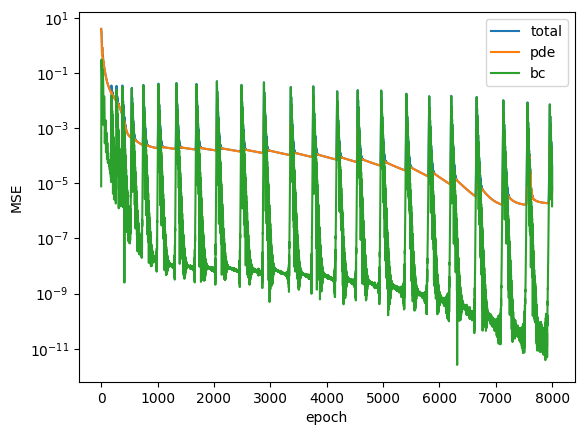

In [27]:
#@title Plot training curves
fig, ax = plt.subplots()
ax.plot(history["total"], label="total")
ax.plot(history["pde"], label="pde")
ax.plot(history["bc"],  label="bc")
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")
ax.set_yscale("log")
ax.legend()
plt.show()


Relative L2 error: 0.026591042056679726


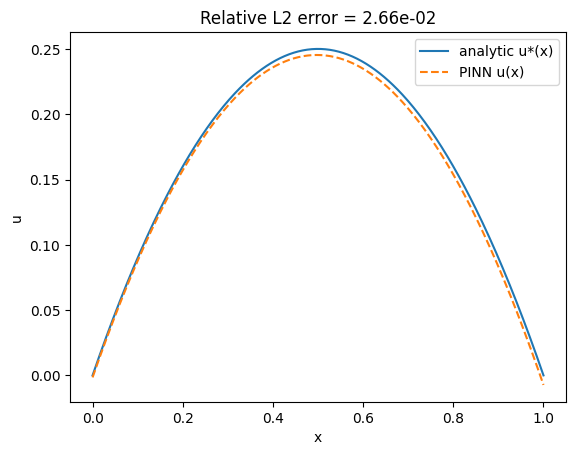

In [28]:
#@title Evaluate against analytic solution
with torch.no_grad():
    x_eval = torch.linspace(x_min, x_max, 400, device=device).unsqueeze(1)
    u_pred = model(x_eval)
    u_true = u_analytic(x_eval)

l2_rel = torch.linalg.norm(u_pred - u_true)/torch.linalg.norm(u_true)
print("Relative L2 error:", l2_rel.item())

# Plot u(x)
x_cpu = x_eval.squeeze().cpu().numpy()
plt.plot(x_cpu, u_true.cpu().numpy(), label="analytic u*(x)")
plt.plot(x_cpu, u_pred.detach().cpu().numpy(), "--", label="PINN u(x)")
plt.xlabel("x"); plt.ylabel("u")
plt.title(f"Relative L2 error = {l2_rel.item():.2e}")
plt.legend(); plt.show()


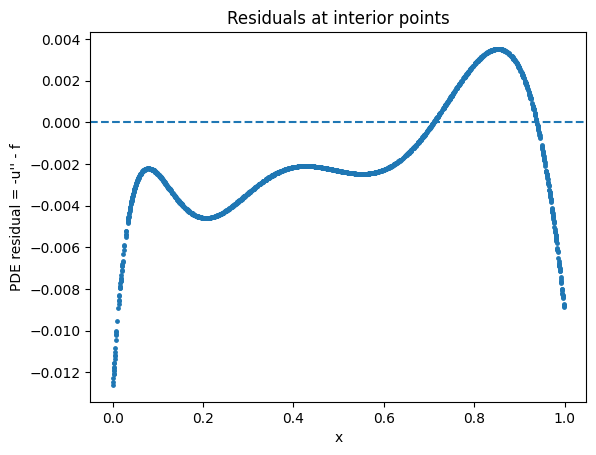

In [29]:
#@title Residual scatter at random interior points
with torch.no_grad():
    xf_vis = torch.rand(2000,1, device=device)*(x_max-x_min)+x_min
xf_vis.requires_grad_(True)
u_vis = model(xf_vis)
u_xx_vis = laplace_1d(u_vis, xf_vis)
res_vis = (-u_xx_vis - f_true(xf_vis)).detach().cpu().numpy()

plt.scatter(xf_vis.detach().cpu().numpy(), res_vis, s=6)
plt.axhline(0, linestyle="--")
plt.xlabel("x"); plt.ylabel("PDE residual = -u'' - f")
plt.title("Residuals at interior points")
plt.show()
